# Concepts for Time Series Forecasting.

Around us exists patterns that repeat constantly over time, you can notice repetitive patterns in the weather with the four seasons in a year; patterns in the traffic jams when you arriving and leaving your job; in heart beats, where you can search for abnormal patterns; in shares of the stock exchange, as well as in the sales cycles of certain products.

Analyzing time series data are useful for checking these patterns and creating predictions of future movements. There are several ways to create these forecasts, in this post I will approach the concepts of the most basic and traditional methodologies.

The codes are going to be in Python, let's import the libraries:

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

# Stationary Series
A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, are relatively constant over time. Thus, a non-stationary series is one whose statistical properties change over time.

Before starting any predictive modeling it is necessary to verify if these statistical properties are constant, I will explain below each of these points:

* Constant mean
* Constant variance
* Auto correlated

## Constant Mean
A stationary series has a relatively constant mean over time, there are no bullish or bearish trends. The reason is that having a constant mean with small variations around it, makes much easier to extrapolate to the future.

There are cases where the variance is small relative to the mean and using it may be a good metric to make predictions for the future, below a chart to show the relative constant mean in relation to the variances over time:

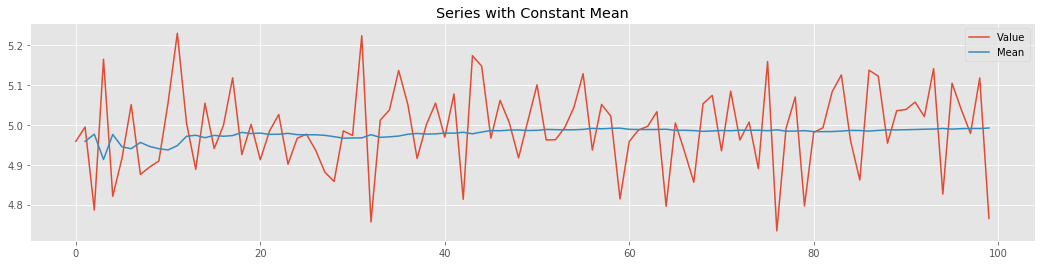

In [3]:
np.random.seed(2)
rand = [5] * 100 + np.random.randn(100) * 0.1


#Creating an average that expands from the first value and accumulate until each day
mean = [np.mean(rand[:x]) for x in range(len(rand))]
plt.figure(figsize=(18,4))
plt.plot(rand, label='Value')
plt.plot(mean, label='Mean')
plt.title('Series with Constant Mean')
plt.legend()
plt.show()


If the series is not stationary the forecast for the future will not be efficient, because variations around the mean values deviate significantly as can be seen below:

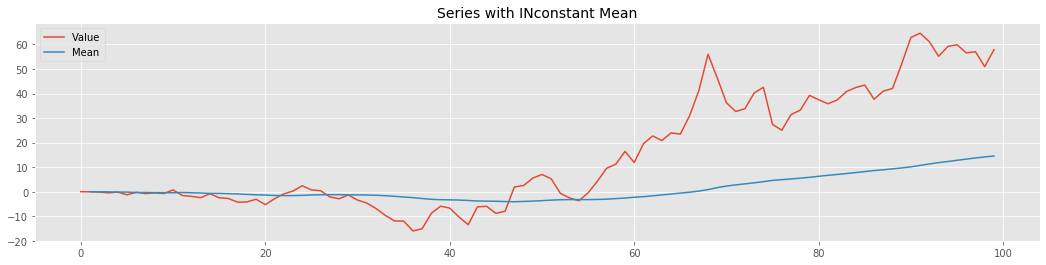

In [4]:
np.random.seed(1)
rand2 = np.cumsum([x for x in range(100) * np.random.randn(100) * 0.1])

#Creating an average that expands from the first value and accumulate until each day
mean2 = [np.mean(rand2[:x]) for x in range(len(rand2))]
plt.figure(figsize=(18,4))
plt.plot(rand2, label='Value')
plt.plot(mean2, label='Mean')
plt.title('Series with INconstant Mean', fontdict={'fontsize':14})
plt.legend()
plt.show()

In the chart above, it is clear that there is a bullish trend and the mean is gradually rising, in this case if the average was used to make future forecasts the error would be significant, since the forecast prices would always be below the real price.

# Constant Variance
When the series has constant variance, we have an idea of the standard variation in relation to the mean, when the variance is not constant (as image below) the forecast will probably have bigger errors in certain periods and these periods will not be predictable, it is expected that the variance will remain inconstant over time, including in the future.

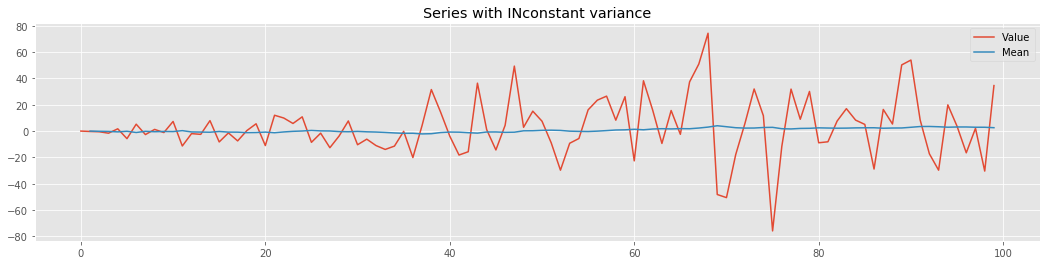

In [5]:
np.random.seed(1)
rand3 = [x for x in range(100) * np.random.randn(100) * 0.5]

#Creating an average that expands from the first value and accumulate until each day
mean3 = [np.mean(rand3[:x]) for x in range(len(rand3))]
plt.figure(figsize=(18,4))
plt.plot(rand3, label='Value')
plt.plot(mean3, label='Mean')
plt.title('Series with INconstant variance')
plt.legend()
plt.show()

To reduce the variance effect, the logarithmic transformation can be applied, also some exponential transformation like the Box-Cox method, or you can use inflation adjustment if it makes sense.

# Autocorrelated Series
When two variables have similar variation in relation to the standard deviation during time you can say that these variables are correlated, an example would be the increase of the body weight with diseases of the heart, the greater the weight the greater the incidence of problems in the heart, in this case the correlation is positive and the graph would look something like this:

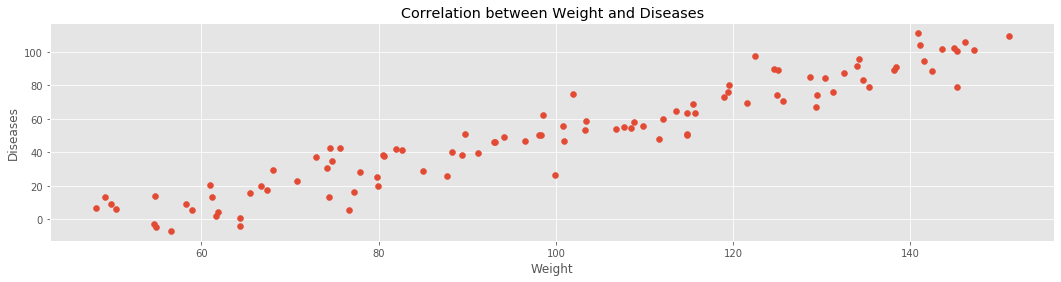

In [6]:
np.random.seed(1)
weight = [x for x in range(50,150)] + np.random.randn(100) * 3
diseases = [x for x in range(100)] + np.random.randn(100) * 10

plt.figure(figsize=(18,4))
plt.scatter(weight, diseases)
plt.xlabel('Weight')
plt.ylabel('Diseases')
plt.title('Correlation between Weight and Diseases')
plt.show()

A case of negative correlation would be something like: the greater the expense with work safety the smaller would be the amount of accidents that would occur.

Here are several examples of scatter plots with correlation levels:

![alt text](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

When the subject is Autocorrelation, it means that there is a correlation of certain previous periods with the current period, the name given to the period with this correlation is lag, for example: in a series that has measurements every hour, today's temperature at 12:00 is very similar to the temperature of 24 hours ago and if you compare the variation of temperatures through the time between these 24 hours period there will be an auto correlation, in this case we will have an autocorrelation with the 24th lag.

Autocorrelation is a condition to create forecasts with a single variable, because if there is no correlation, you can not use past values to predict the future, when there are several variables, you can verify if there is a correlation between the dependent variable and the lags of the independent variables.

If a series does not have autocorrelation it is a series with random and unpredictable sequences and the best way to make a prediction is usually to use the value from the previous day. I will use more detailed charts and explanations below.

## Example with Real World Data

In [7]:
import pandas_datareader as pdr

In [8]:
aapl = pdr.get_data_yahoo('AAPL', '2010')

In [9]:
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,30.478571,30.080000,30.447144,30.104286,88102700.0,26.131752
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.538483
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.584366
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.161509
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.113146


## Let's Focus on the Close Price

In [10]:
aapl_c = aapl[['Close']]
aapl_c.head()

,Close
Date,
2009-12-31,30.104286
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857


# Dividing data on training and testing basis
When we are going to create a time series prediction model, it's crucial to separate the data into two parts:

Training set: these data will be the main basis for defining the coefficients / parameters of the model;

Test set: These are the data that will be separated and not seen by the model and will be used to test if the model works (generally these values are compared with a walk forward method and finally the mean error is measured).

The size of the test set is usually about 20% of the total sample, although this percentage depends on the sample size that you have and also how much time ahead you want to make the forecast. The test set should ideally be at least as large as the maximum forecast horizon required.

Unlike other prediction methods, such as classifications and regressions without the influence of time, in time series we can not divide the training and test data with random samples from any part of the data, we must follow the time criterion of the series, where the training data should always come before the test data.


In [11]:
train = aapl_c[aapl_c.index < datetime(year=2019, month=3, day=1, hour=0)]
test = aapl_c[aapl_c.index >= datetime(year=2019, month=3, day=1, hour=0)]

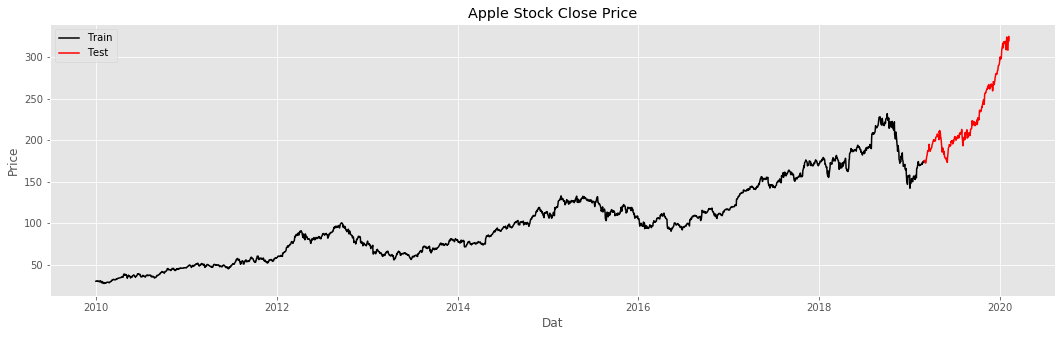

In [12]:
plt.figure(figsize=(18,5))
plt.title('Apple Stock Close Price')
plt.plot(train['Close'], color='black')
plt.plot(test['Close'], color='red')
plt.legend(['Train','Test'])
plt.xlabel('Dat')
plt.ylabel('Price')
plt.show()

From now on we will only use the training set to do the studies, the test set will only be used to validate the predictions that we will make.

Every time series can be broken down into 3 parts: trend, seasonality and residuals, which is what remains after removing the first two parts from the series, below the separation of these parts:

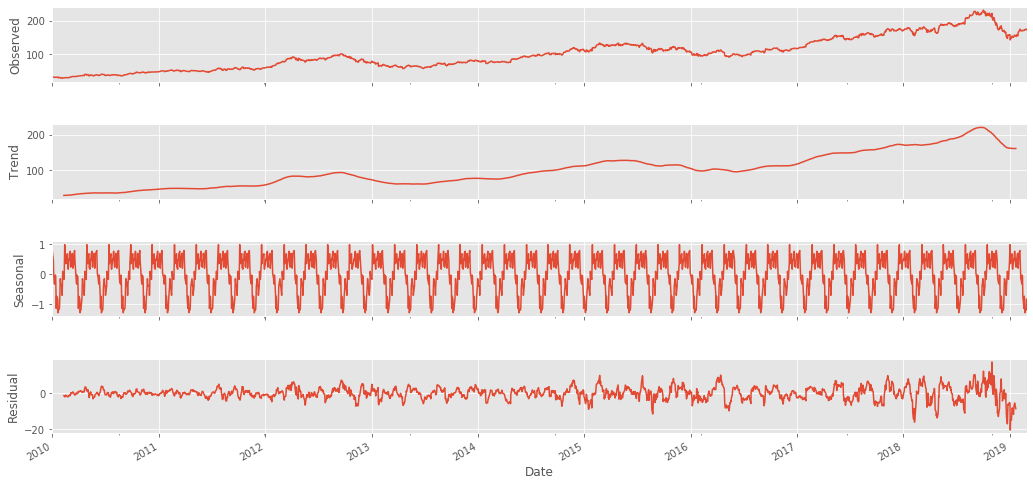

In [13]:
# weekly chart with cycles that repeat every 52 weeks (1 year)
season = seasonal_decompose(train, freq=52)
fig = season.plot();
fig.set_size_inches(16,8)

Clearly the series has an uptrend, with peaks between the end and beginning of each years. 

However it is indicated to use statistical tests to confirm if the series is stationary, we will use two tests: the Dickey Fuller test and the KPSS test.

First we will use the Dickey Fuller test, I will use the base P value of 5%, that is, if the P value is below these 5% it means that the series is statistically stationary.

In addition, there is the Statistical Test of the model, where these values can be compared with the critical values of 1%, 5% and 10%, if the statistical test is below some critical value chosen the series will be stationary:

In [14]:
#Dickey Fuller Test
adfinput = adfuller(train['Close'])
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 
adftest

Dickey Fuller Statistical Test      -1.0864
P-value                              0.7205
Used Lags                           27.0000
Number of comments used           2277.0000
Critical Value (1%)                 -3.4332
Critical Value (5%)                 -2.8628
Critical Value (10%)                -2.5674
dtype: float64

In this case the Dickey Fuller test indicated that the series is not stationary (P value 72% and the critical value 5% is less than the statistical test)

Now we are going to analyze the series with the KPSS test, unlike the Dickey Fuller test, the KPSS test already assumes that the series is stationary and only will not be if the P value is less than 5% or the statistical test is less than some critical value:

In [15]:
kpss_input = kpss(train['Close'])
kpss_test = pd.Series(kpss_input[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)"%key] = value 
kpss_test

Statistical Test KPSS     7.1252
P-Value                   0.0100
Used Lags                27.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

Confirming the Dickey Fuller test, the KPSS test also shows that the series is not stationary because the P value is at 1% and the statistical test is above any critical value.

Next I will demonstrate ways to turn a series into stationary.

# Turning the series into stationary
Differentiation
Differentiation is used to remove trend signals and also to reduce the variance, it is simply the difference of the value of period T with the value of the previous period T-1.

To make it easier to understand, below we get only a fraction of close price from a shorter period.

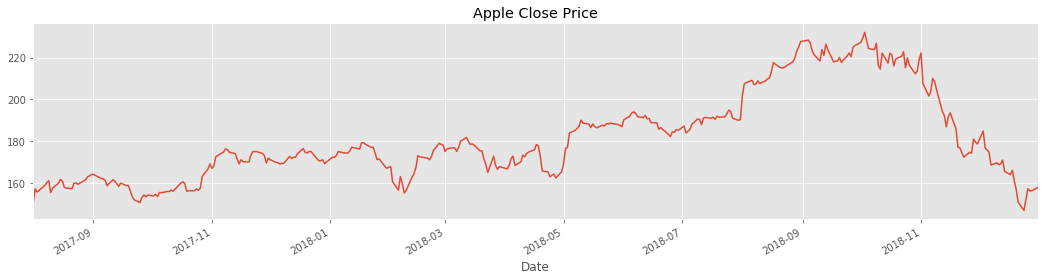

In [16]:
train.loc['2017-8':'2018','Close'].plot(figsize=(18,4), title='Apple Close Price')
plt.show()

When the first differentiation is made (graph below), we remove the cumulative effect of the series and only show the variation of period T against period T-1 throughout the whole series, so if the price of 3 days ago was 250.00 and changed to 275.00, the value of the differentiation will be 25.00 and if today's value is 260.00 then the difference will be -15.00.

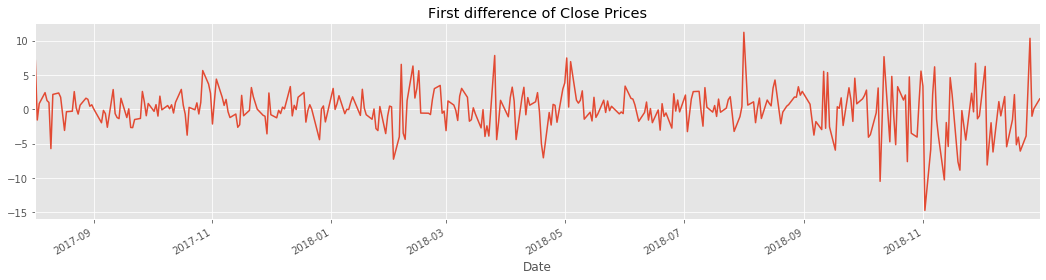

Showing the first 10 differentiations


Date
2017-08-02    7.089996
2017-08-03   -1.569992
2017-08-04    0.819992
2017-08-07    2.419998
2017-08-08    1.270004
Name: Close, dtype: float64

In [17]:
train.loc['2017-8':'2018','Close'].diff().dropna().plot(figsize=(18,4))
plt.title('First difference of Close Prices')
plt.show()
print('Showing the first 10 differentiations')
train.loc['2017-8':'2018','Close'].diff().dropna().head()

Normally only a differentiation is necessary to transform a series into stationary, but if necessary, a second differentiation can be applied, in this case the differentiation will be made on the values of the first differentiation (there will hardly be cases with more than 2 differentiations).

Using the same example, to make a second differentiation we must take the differentiation of T minus T-1: 2.9 - 5.5 = -2.6 and so on.

In [18]:
# Differentiation of differentiation
print('Second differentiation')
train['Close'].diff().diff().dropna().head(10)

Second differentiation


Date
2010-01-05   -0.415714
2010-01-06   -0.539999
2010-01-07    0.431429
2010-01-08    0.255714
2010-01-11   -0.467144
2010-01-12   -0.074286
2010-01-13    0.760000
2010-01-14   -0.592857
2010-01-15   -0.325714
2010-01-19    1.801428
Name: Close, dtype: float64

Let's do the Dickey fuller test to see if the series will be stationary with the first differentiation:

In [19]:
#creating a function to plot the graph and show the test result:
def adfuller_test(series, figsize=(18,4), plot=True, title=""):
    if plot:
        series.plot(figsize=figsize, title=title)
        plt.show()
    #Dickey Fuller test on the first differentiation
    adf = adfuller(series)
    output = pd.Series(adf[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                        'Used Lags', 'Number of comments used'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Critical Value (%s)"%key] = value.round(4) 
    return output

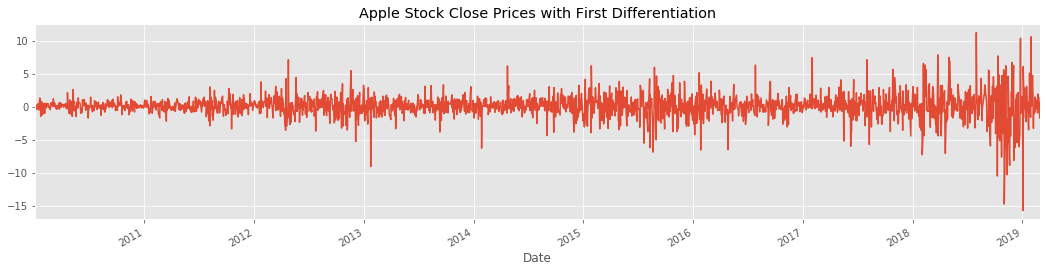

Dickey Fuller Statistical Test      -7.5935
P-value                              0.0000
Used Lags                           27.0000
Number of comments used           2276.0000
Critical Value (1%)                 -3.4332
Critical Value (5%)                 -2.8628
Critical Value (10%)                -2.5674
dtype: float64

In [20]:
adfuller_test(train['Close'].diff().dropna(), title='Apple Stock Close Prices with First Differentiation')

In this case we confirm that the series is stationary, the value P is zero and if we compare, the value of the statistical test is far below the critical values.


## Reducing variance
### Logarithm
The logarithm is usually used to transform series that have exponential growth values in series with more linear growths, in this example we will use the Natural Logarithm (NL), where the base is 2.718, this type of logarithm is widely used in economic models.

The difference of the values transformed into NL are approximately equivalent to the percentage variation of the values of the original series, which is valid as a basis for reducing the variance in series with different prices, see the example below:

If we had a price increase in 2015 and went from 50.00 to 52.50, some years later (2019) the price was already 100.00 and changed to 105.00 , the absolute difference between prices is 2.50 and 5.00 respectively, however the percentage difference of both is 5%.

When we use the NL in these prices we have: NL (52,50) - NL (50,00) = 3.96 - 3.912 = 0.048 or 4.8%, in the same way using the NL in the second price sequence we have: NL (105) - NL (100) = 4.654 - 4.605 = 0.049 or 4.9%.

In this example we can reduce the variation of values by bringing almost everything to the same basis of variation.

Below the same example:

In [21]:
price1 = np.log(52.5) - np.log(50)
price2 = np.log(105) - np.log(100)
print(f'The percentage variation of the first example is {round(price1*100,1)} and the second is {round(price2*100,1)}')

The percentage variation of the first example is 4.9 and the second is 4.9


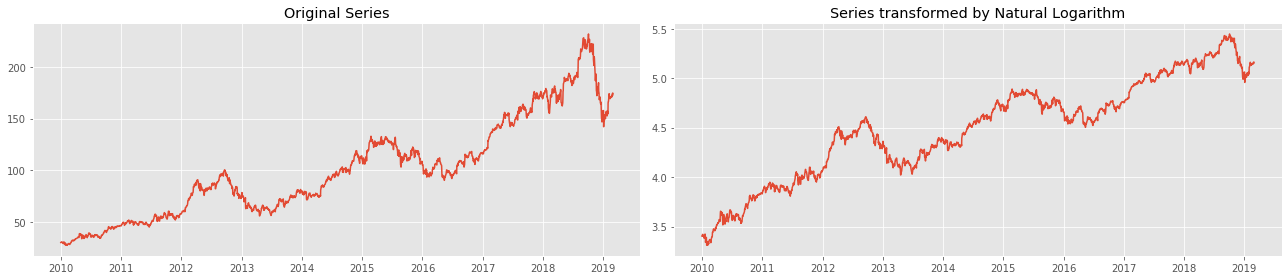

In [22]:
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(train['Close'])
plt.title('Original Series')

#Transformed Series by NL
log = np.log(train['Close'])
plt.subplot(122)
plt.plot(log)
plt.title('Series transformed by Natural Logarithm')
plt.tight_layout()
plt.show()

## Box-Cox Transformation (Power Transform)
The BOX COX transformation is also a way to transform a series, the lambda (λ) value is a parameter used to transform the series.

In short, this function is the junction of several exponential transformation functions, where we search for the best value of lambda that transforms the series so that it has a distribution closer to a normal Gaussian distribution. A condition to use this transformation is that the series only has positive values, the formula is:

### $$
X=\left\{\begin{array}{ll}{\frac{X^{\lambda}-1}{\lambda},} & {\text { if } \lambda \neq 0} \\ {\ln (X)} & {\text { if } \lambda=0}\end{array}\right.
$$


Below I will plot the original series with its distribution and after that the transformed series with the optimal value of lambda with its new distribution, to find the value of lambda we will use the function boxcox of the library Scipy, where it generates the transformed series and the ideal lambda:

The Lambda value was 0.26859064502411817


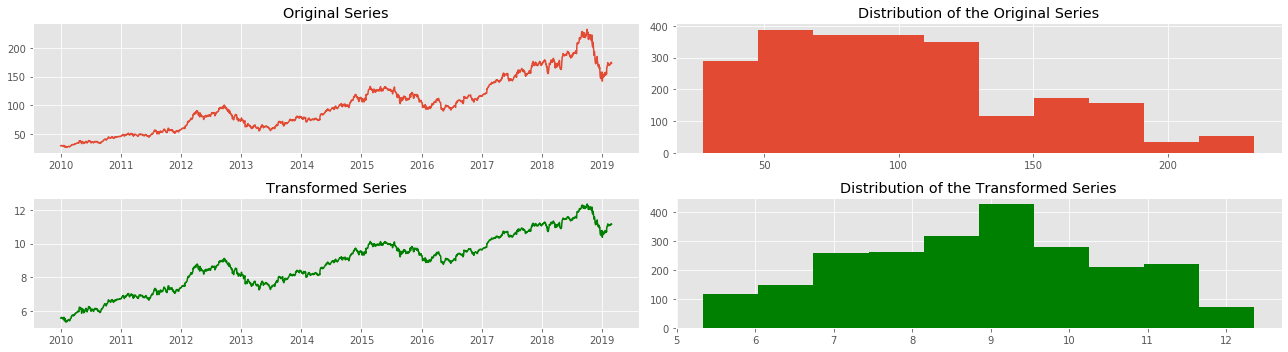

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(221)
plt.plot(train['Close'])
plt.title('Original Series')

plt.subplot(222)
plt.hist(train['Close'])
plt.title('Distribution of the Original Series')

#Transforming the series
from scipy.stats import boxcox
train['BOXCOX'], lmbda_ = boxcox(train['Close'])
print(f'The Lambda value was {lmbda_}')

plt.subplot(223)
plt.plot(train['BOXCOX'], color='green')
plt.title('Transformed Series')

plt.subplot(224)
plt.hist(train['BOXCOX'], color='green')
plt.title('Distribution of the Transformed Series')
plt.tight_layout()

Below is an interactive chart where you can change the lambda value and check the change in the chart

In [24]:
import ipywidgets as widgets
from ipywidgets import interactive

def f(lmbda):
    plt.figure(figsize=(18,4))
    if lmbda == 0:
        train['Box Cox'] = np.log(train['Close'])
    else:
        train['Box Cox'] = (train['Close']**lmbda - 1)/lmbda
    plt.plot(train['Box Cox'])
    plt.title(f'Box Cox Transformation with Lambda {lmbda}', fontdict={'fontsize':16})
    plt.show()

widgets.interact(f, lmbda=(-5,5,0.5))

interactive(children=(FloatSlider(value=0.0, description='lmbda', max=5.0, min=-5.0, step=0.5), Output()), _do…

<function __main__.f(lmbda)>

This tool is usually used to improve the performance of the model, since it makes it with more normal distributions, remembering that after finishing the prediction of the model, you must return to the original base inverting the transformation according to the formula below:

### $$
X=\left\{\begin{array}{ll}{(X \lambda+1)^{1 / \lambda},} & {\text { if } \lambda \neq 0} \\ {\exp (X)} & {\text { if } \lambda=0}\end{array}\right.
$$

## Looking for correlated lags
To be predictable a series with a single variable must have auto-correlation, that is, the current period must be explained based on an earlier period (a lag).

As this series has Daily periods, 1 year is approximately 365 Days, I will use the auto correlation function showing a period of 60 lags to verify correlations of the current period with these lags.

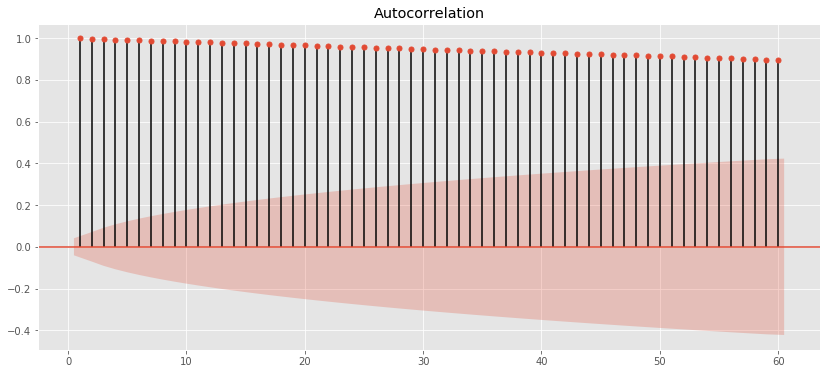

In [25]:
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
plot_acf(train['Close'], lags=60, zero=False, ax=ax);

Analyzing the above autocorrelation chart it seems that all lags could be used to create forecasts for future events, since they have a positive correlation close to 1 and they are also outside of the confidence interval, but this autocorrelation characteristic is of a non-stationary series.

Another very important function is the partial autocorrelation function, where the effect of previous lags on the current period are removed and only the effect of the lag analyzed over the current period remains, for example: the partial autocorrelation of the fourth lag will remove the effects of the first, second and third lags.

Below the partial autocorrelation graph:

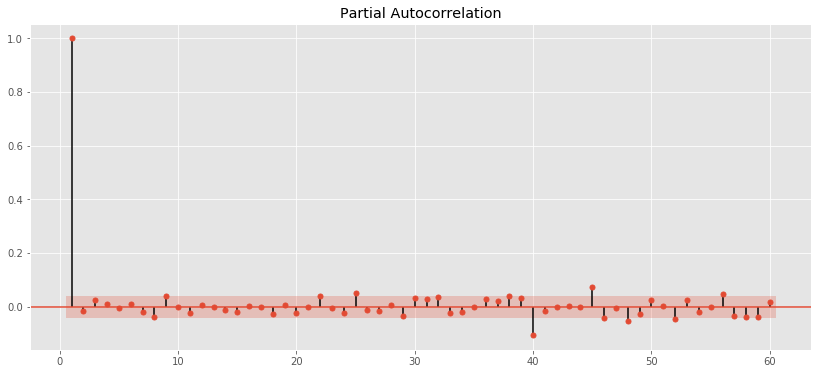

In [26]:
plt.figure(figsize=(14,6))
ax = plt.subplot(111)
plot_pacf(train['Close'], lags=60, zero=False, ax=ax);

As can be seen, almost no lag has an effect on the current period, but as demonstrated earlier, the series without differentiation is not stationary, we will now plot these two functions with the series with a differentiation to see how it works:

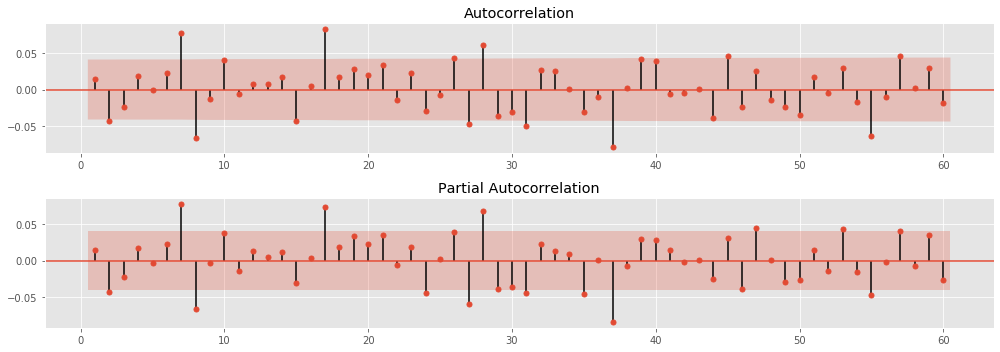

In [27]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(211)
plot_acf(train['Close'].diff().dropna(), lags=60, zero=False, ax=ax1);
ax2 = plt.subplot(212)
plot_pacf(train['Close'].diff().dropna(), lags=60, zero=False, ax=ax2);
plt.tight_layout()

The autocorrelation plot changed significantly, showing that the series has significant correlation in the seventh, 17th lag etc., and negative correlation eighth, 36th lag etc.

To create forecasts, we must pay attention to an extremely important detail about finding correlated lags, it's important that there is a reason behind this correlation, because if there is no logical reason it's possible that it's only chance and that this correlation can disappear when you include more data.

Another important point is that the autocorrelation and partial autocorrelation graphs are very sensitive to outliers, so it's important to analyze the time series itself and compare with the two autocorrelation charts.

# Metrics to evaluate the model
In order to analyze if the forecasts are with the values close to the current values one must make the measurement of the error, the error (or residuals) in this case is basically Yreal−Ypred.

The error in the training data is evaluated to verify if the model has good assertiveness, and validates the model by checking the error in the test data (data that was not "seen" by the model).

Checking the error is very important to verify if your model is overfitting or underfitting when you compare the training data with the test data.

Below are the key metrics used to evaluate time series models:

# MEAN FORECAST ERROR - (BIAS)
It's nothing more than the average of the errors of the evaluated series, the values can be positive or negative. This metric suggests that the model tends to make predictions above the real (negative errors) or below the real (positive errors), so it can also be said that the mean error is the bias of the model.

# MAE - MEAN ABSOLUTE ERROR
This metric is very similar to the average error of the prediction mentioned above, the only difference is the error with negative value that is transformed into positive and afterwards the mean is calculated.

This metric is widely used in time series, since there are cases that the negative error can cancel the positive error and give an idea that the model is accurate, in the case of the MAE it doesn't happen, because this metric shows how much the forecast is far from the real values, regardless if above or below, see the case below:

In [28]:
a = np.array([1,2,3,4,5])
b = np.array([5,4,3,2,1])

error = a - b

MFE = error.mean()
MAE = np.abs(error).mean()

print(f'The error of each model value looks like this: {error}')
print(f'The MFE error was {MFE}, the MAE error was {MAE}')

The error of each model value looks like this: [-4 -2  0  2  4]
The MFE error was 0.0, the MAE error was 2.4


# MSE - MEAN SQUARED ERROR
This metric places more weight on larger errors because each individual error value is squared and then the mean of those values is calculated. Thus, this metric is very sensitive to outliers and puts a lot of weight on predictions with more significant errors.

Unlike the MAE and MFE, the MSE values are in quadratic units rather than the units of the model.

# RMSE - ROOT MEAN SQUARED ERROR
This metric is simply the square root of the MSE, where the error returns to the unit of measure of the model (BRL/ m3), it is very used in time series because it's more sensitive to the bigger errors due to the process of squaring which originated it.

# MAPE - MEAN ABSOLUTE PERCENTAGE ERROR
This is another interesting metric to use, which is generally used in management reports because the error is measured in percentage terms and you can compare the percent error of the model of a product X with the percentage error of a product Y.

The calculation of this metric takes the absolute value of the error divided by the current price then the mean is calculated:

### $$
\mathrm{MAPE}=\frac{100 \%}{n} \sum_{t=1}^{n}\left|\frac{Y_{R E A L}-Y_{P R E D}}{Y_{R E A L}}\right|
$$

Let's create a function to evaluate the errors of the training and test data with several evaluation metrics:

In [29]:
#Libraries to create the function:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_error(orig, pred, name_col='', index_name=''):
    
    bias = np.mean(orig - pred)
    mse = mean_squared_error(orig, pred)
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    mape = np.mean(np.abs((orig - pred) / orig)) * 100
    
    error_group = [bias, mse, rmse, mae, mape]
    series = pd.DataFrame(error_group, index=['BIAS','MSE','RMSE','MAE', 'MAPE'], columns=[name_col])
    series.index.name = index_name
    
    return series

## Checking the residual values¶
It's not enough to create the model and check the error values according to the chosen metric, you must also analyze the characteristics of the residual itself, as there are cases where the model can not capture the information necessary to make a good forecast resulting in a error with information that should be used to improve the forecast.

To verify this residual we will check:

* Actual vs. predicted values (sequential chart);

* Residual vs. predicted values (dispersion chart):

    * It is very important to analyze this graph, since in it we can check patterns that can tell us if some modification is needed in the model, the ideal is that the error is distributed linearly along the forecast sequence.

* QQ plot of the residual (dispersion chart):

    * Summarizing this is a graph that shows where the residue should be theoretically distributed, following a Gaussian distribution, versus how it actually is.

* Residual autocorrelation (sequential chart):

    * Where there should be no values that come out of the confidence margin, or the model is leaving information out of the model.
    
We need to create another function to plot these graphs:

In [30]:
def plot_error(data, figsize=(18,8)):
    
    # Creating the column error
    data['Error'] = data.iloc[:,0] - data.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting actual and predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Real Value vs Prediction')
    
    # Error vs Predicted value
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residual')
    ax2.set_title('Residual vs Predicted Values')
    
    ## Residual QQ Plot
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation Plot of residual
    plot_acf(data.iloc[:,2], lags=60, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

# Most basic ways to make a forecast
From now on we will create some models of price forecast of Apple stock close price. These kind of stock price prediction is extremely difficult as we have seen from the autocorrlation and partial autocorrelation plot that past values are not a direct indicator of future values, below will be the steps that we will follow for each model:

* Create prediction on the training data and subsequently validate on the test data;
* Check the error of each model according to the metrics mentioned above;
* Plot the model with the residual comparatives.

## Simple approach:
The simplest way to make a forecast is to use the value of the previous period, there are cases that this is the best approach that can be done, where the error is lower than the other forms of forecast, but using this methodology to predict several periods ahead generally doesn't work well, as the errors in relation to real values tend to increase.

Many people also use this approach as baseline to try to improve with more complex models.

Below we will use the training and test data to make the simulations:

In [31]:
#Creating the training variable to compare with the error later
simple_train = train[['Close']]
simple_train.columns = ['Real']
simple_train['Pred'] = simple_train['Real'].shift()
simple_train.dropna(inplace=True)

SIMPLE MODEL IN THE TRAINING DATA


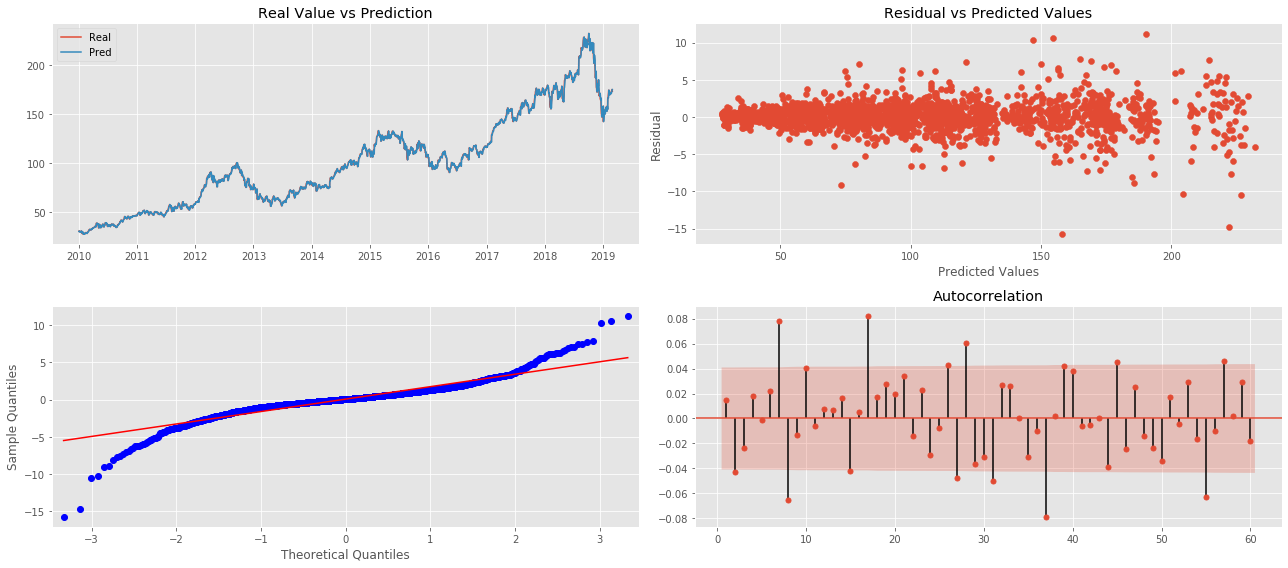

,Simple
Training Base,
BIAS,0.062086
MSE,3.165090
RMSE,1.779070
MAE,1.142651
MAPE,1.165018


In [32]:
# Let's create a variable to check the training error of this model, we will also plot the graphs mentioned above:
error_train = check_error(simple_train['Real'], 
                         simple_train['Pred'], 
                         name_col='Simple', 
                         index_name='Training Base')

print('SIMPLE MODEL IN THE TRAINING DATA')
plot_error(simple_train)
error_train

The QQ graph shows that there are some larger (up and down) residuals than theoretically should be, these are the so-called outliers, and there is still a significant autocorrelation in the 7, 8 and 17 lag, which could be used to improve the model.

In [33]:
simple_train.tail()

,Real,Pred,Error
Date,,,
2019-02-22,172.970001,171.059998,1.910004
2019-02-25,174.229996,172.970001,1.259995
2019-02-26,174.330002,174.229996,0.100006
2019-02-27,174.869995,174.330002,0.539993
2019-02-28,173.149994,174.869995,-1.720001


In [36]:
simple_test = test[['Close']]
simple_test.columns = ['Real']

hist = simple_train.Real.values.tolist()
pred = []
for t in range(len(simple_test)):
    yhat = hist[-1]
    obs = simple_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    if t<10:
        print(yhat, obs, pred)

173.14999389648438 174.97000122070312 [173.14999389648438]
174.97000122070312 175.85000610351562 [173.14999389648438, 174.97000122070312]
175.85000610351562 175.52999877929688 [173.14999389648438, 174.97000122070312, 175.85000610351562]
175.52999877929688 174.52000427246094 [173.14999389648438, 174.97000122070312, 175.85000610351562, 175.52999877929688]
174.52000427246094 172.5 [173.14999389648438, 174.97000122070312, 175.85000610351562, 175.52999877929688, 174.52000427246094]
172.5 172.91000366210938 [173.14999389648438, 174.97000122070312, 175.85000610351562, 175.52999877929688, 174.52000427246094, 172.5]
172.91000366210938 178.89999389648438 [173.14999389648438, 174.97000122070312, 175.85000610351562, 175.52999877929688, 174.52000427246094, 172.5, 172.91000366210938]
178.89999389648438 180.91000366210938 [173.14999389648438, 174.97000122070312, 175.85000610351562, 175.52999877929688, 174.52000427246094, 172.5, 172.91000366210938, 178.89999389648438]
180.91000366210938 181.7100067138

SIMPLE MODEL IN THE TEST DATA


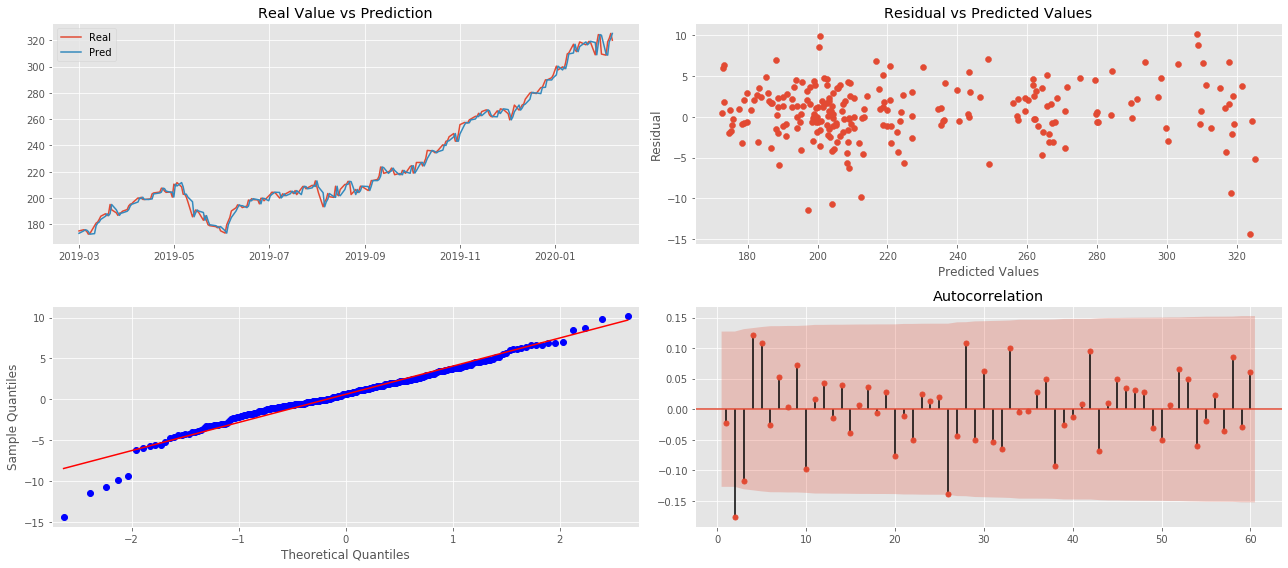

,Simple
Testing Base,
BIAS,0.617143
MSE,12.223257
RMSE,3.496177
MAE,2.598739
MAPE,1.150317


In [37]:
simple_test = test[['Close']]
simple_test.columns = ['Real']

#adding the first value of the Forecast with the last Actual data of the test
hist = simple_train.Real.values.tolist()

pred = []
for t in range(len(simple_test)):
    yhat = hist[-1]
    obs = simple_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)

simple_test['Pred'] = pred

#creating the basis of error in the test
error_test = check_error(simple_test['Real'], 
                        simple_test['Pred'], 
                        name_col='Simple',
                       index_name='Testing Base')

print('SIMPLE MODEL IN THE TEST DATA')
plot_error(simple_test)
error_test

The RMSE and MAE errors were similar to the training data, the QQ chart is with the residual more in line with what should theoretically be, probably due to the few sample values compared to the training data.

In the chart comparing the residuals with the predicted values it's noted that there is a tendency for the errors to increase in absolute values when prices increase, perhaps a logarithmic adjustment would decrease this error expansion, and to finalize the residual correlation graph show that there is still room for improvement as there is a strong correlation in the first lag, where a regression based on the first lag could probably be added to improve predictions.Next model is the simple average:

## Simple Mean:
Another way to make predictions is to use the series mean, usually this form of forecasting is good when the values oscillate close around the mean, with constant variance and no uptrend or downtrend, but it's possible to use better methods, where can make the forecast using seasonal patterns among others.

This model uses the mean of the beginning of the data until the previous period analysed and it expands daily until the end of the data, in the end the tendency is that the line is straight, we will now compare the error of this model with the first model:

In [38]:
sm_train = train[['Close']]
sm_train.columns = ['Real']
sm_train['Pred'] = sm_train['Real'].expanding().mean()

#Verifying the Simple Mean Template Error
error_train['Simple Mean'] = check_error(sm_train['Real'], sm_train['Pred'])
error_train.round(4)

,Simple,Simple Mean
Training Base,,
BIAS,0.0621,36.4463
MSE,3.1651,2218.4551
RMSE,1.7791,47.1005
MAE,1.1427,36.4771
MAPE,1.1650,30.5682


In testing data I will continue to use the mean from the beginning of the training data and make the expansion of the mean in accordance with the values that will be added on the test data:

SIMPLE MEAN MODEL IN THE TEST DATA


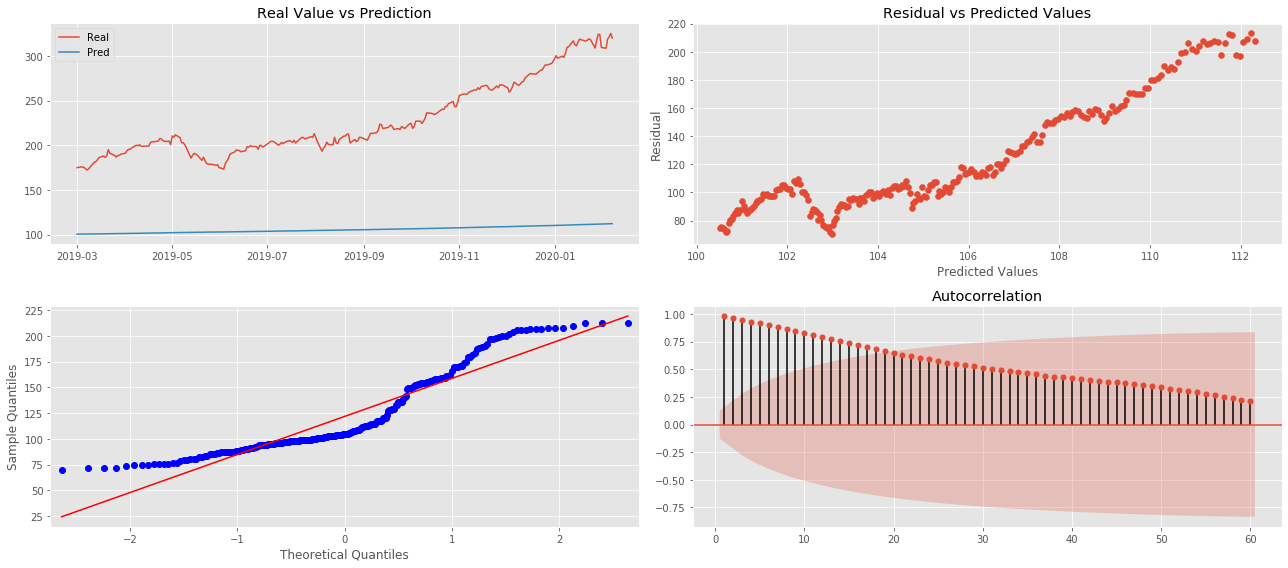

,Simple,Simple Mean
Testing Base,,
BIAS,0.617143,121.865812
MSE,12.223257,16338.736850
RMSE,3.496177,127.823069
MAE,2.598739,121.865812
MAPE,1.150317,52.407769


In [39]:
sm_test = test[['Close']]
sm_test.columns = ['Real']

# Continuing to use the average for the test series
hist = sm_train.Real.values.tolist()
pred = []
for t in range(len(sm_test)):
    yhat = np.mean(hist)
    obs = sm_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)

sm_test['Pred'] = pred

#ploting the test chart
print('SIMPLE MEAN MODEL IN THE TEST DATA')
plot_error(sm_test)

#Adding the simple mean error in the test:
error_test['Simple Mean'] = check_error(sm_test['Real'], sm_test['Pred'])
error_test

The simple mean model failed to capture relevant information from the price series, as can be seen in the Real vs Forecast graph as well as in the correlation and Residual vs. Predicted graphs.

## Simple Moving Average:
The moving average is an average that is calculated for a given period (5 days for example) and is moving and always being calculated using this particular period, in which case we will always be using the average for the last 5 days to predict the value of the next day .

In [40]:
sma_train = train[['Close']]
sma_train.columns = ['Real']
sma_train['Pred'] = sma_train.rolling(5).mean()
sma_train.dropna(inplace=True)

# Checking the error of the moving averages on the training model
error_train['5D Moving Avg'] = check_error(sma_train['Real'], sma_train['Pred'])
error_train.round(4)

,Simple,Simple Mean,5D Moving Avg
Training Base,,,
BIAS,0.0621,36.4463,0.1249
MSE,3.1651,2218.4551,3.7457
RMSE,1.7791,47.1005,1.9354
MAE,1.1427,36.4771,1.3192
MAPE,1.1650,30.5682,1.3582


The error was lower than the simple average, but still above the simple model, below the test model

5-DAY MOVING AVERAGE MODEL ON THE TEST DATA


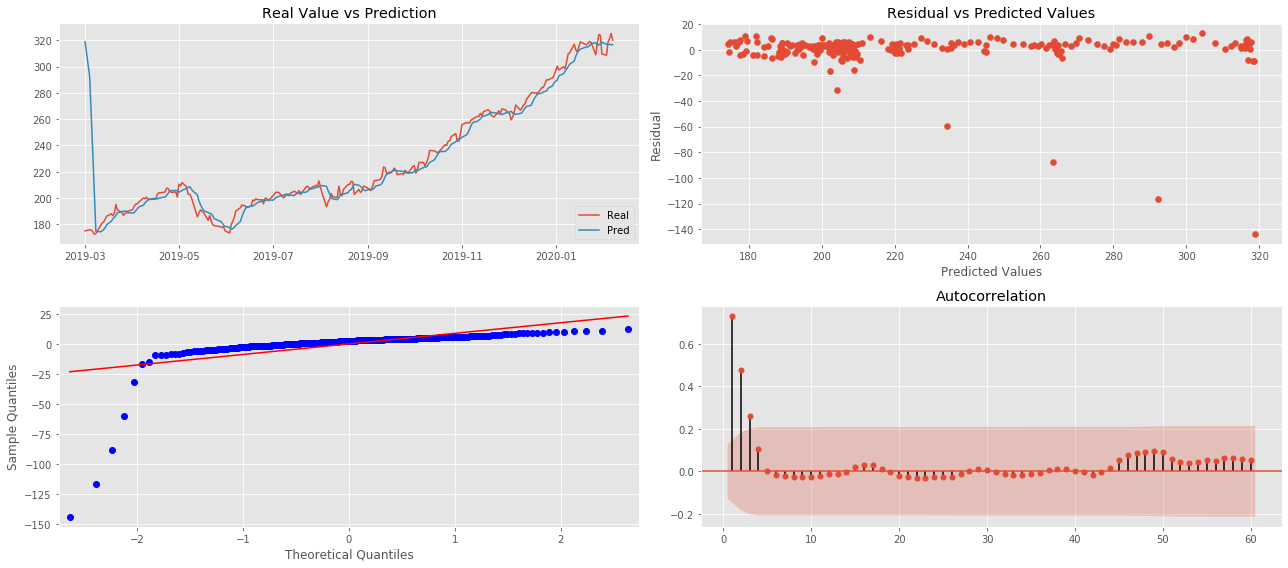

,Simple,Simple Mean,5D Moving Avg
Testing Base,,,
BIAS,0.617143,121.865812,0.000000
MSE,12.223257,16338.736850,218.741504
RMSE,3.496177,127.823069,14.789912
MAE,2.598739,121.865812,5.731294
MAPE,1.150317,52.407769,2.779373


In [41]:
sma_test = test[['Close']]
sma_test.columns = ['Real']

# Continuing to use the 5-day moving average step by step:
hist = sma_test.Real.values.tolist()
pred = []
for t in range(len(sma_test)):
    yhat = np.mean(hist[-5:])
    obs = sma_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    
sma_test['Pred'] = pred

#plotting the test chart
print('5-DAY MOVING AVERAGE MODEL ON THE TEST DATA')
plot_error(sma_test)

# Checking the error of the moving average on test model
error_test['5D Moving Avg'] = check_error(sma_test['Real'], sma_test['Pred'])
error_test

Similarly to the training data, the moving-averages model is better than the simple average, but they do not yet gain from the simple model.

The predictions are with auto-correlation in two lags and the error is with a very high variance in relation to the predicted values.

## Exponential Moving Average:
The simple moving average model described above has the property of treating the last X observations equally and completely ignoring all previous observations. Intuitively, past data should be discounted more gradually, for example, the most recent observation should theoretically be slightly more important than the second most recent, and the second most recent should have a little more importance than the third more recent, and so on, the Exponential Moving Average (EMM) model does this.

Since α (alpha) is a constant with a value between 0 and 1, we will calculate the forecast with the following formula:

Ypredt=Ypredt−1+α(Yt−1−Ypredt−1)
Where the first value of the forecast is the respective current value, the other values will be updated by α times the difference between the actual value and the forecast of the previous period. When alpha is zero we have a constant based on the first value of the forecast, when α is 1 we have a model with simple approach, because the result is the value of the previous real period.

Below is a graph chart several values of α:

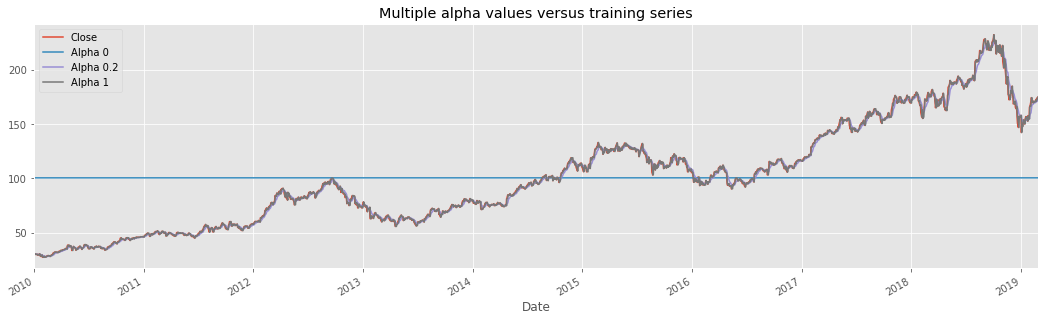

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
emm = train[['Close']]
alpha_ = [0, 0.2, 1]
for key, value in enumerate(alpha_):
    model = ExponentialSmoothing(emm['Close']).fit(smoothing_level= value)
    emm[f'Alpha {value}'] = model.predict(start=0, end=len(emm)-1)

#plotting part of the graph to improve visualization
emm.plot(figsize=(18,5), title='Multiple alpha values versus training series')
plt.show()


The average data period in the EMM forecast is 1 / α . For example, when α = 0.5, lag is equivalent to 2 periods; when α = 0.2 the lag is 5 periods; when α = 0.1 the lag is 10 periods and so on.

In this model we will arbitrarily use a α of 0.50, but you can do a grid search to look for the α which reduces the error in the training and also in the validation, we will see how it will look:

In [43]:
emm_train = train[['Close']]
emm_train.columns = ['Real']

# Creating the model:
alpha = 0.5
model = ExponentialSmoothing(emm_train['Real']).fit(smoothing_level= alpha)
emm_train['Pred'] = model.predict(start=0, end=len(emm_train)-1)

# Checking the error of the exponential moving averages training model
error_train['Exp. Moving Avg'] = check_error(emm_train['Real'], emm_train['Pred'])
error_train

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg
Training Base,,,,
BIAS,0.062086,36.446277,0.124852,0.124461
MSE,3.165090,2218.455104,3.745675,4.191270
RMSE,1.779070,47.100479,1.935375,2.047259
MAE,1.142651,36.477070,1.319181,1.371533
MAPE,1.165018,30.568219,1.358241,1.408435


The error of this model was similar to the error of the moving averages, however we have to validate the model in the test base:

In [44]:
emm_train.head(2)

,Real,Pred
Date,,
2009-12-31,30.104286,30.288026
2010-01-04,30.572857,30.196156


EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA


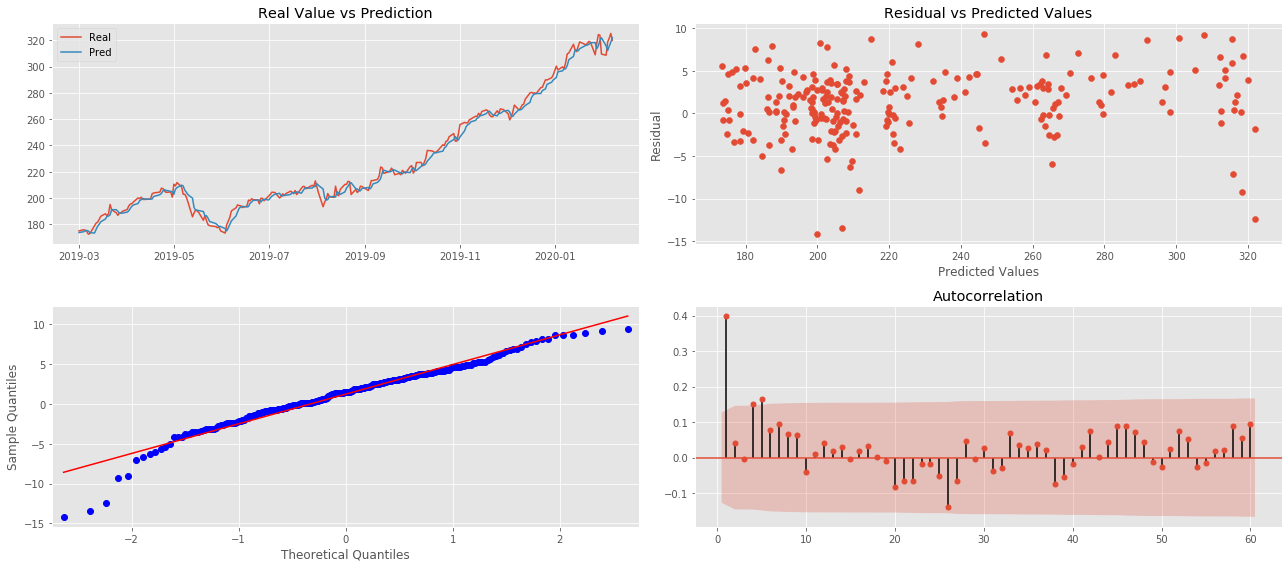

,Simple,Simple Mean,5D Moving Avg,Exp. Moving Avg
Testing Base,,,,
BIAS,0.617143,121.865812,0.000000,1.237057
MSE,12.223257,16338.736850,218.741504,15.443017
RMSE,3.496177,127.823069,14.789912,3.929760
MAE,2.598739,121.865812,5.731294,3.045022
MAPE,1.150317,52.407769,2.779373,1.347371


In [45]:
emm_test = test[['Close']]
emm_test.columns = ['Real']

#creating the model
hist = emm_train.Real.values.tolist()
hist_pred = emm_train.Pred.values.tolist()
pred = []
for t in range(len(emm_test)):
    yhat = hist_pred[-1] + alpha * (hist[-1] - hist_pred[-1])
    obs = emm_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    hist_pred.append(yhat)

emm_test['Pred'] = pred

#plotting the test chart
print('EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA')
plot_error(emm_test)

# Checking the error of the exponential moving averages test model
error_test['Exp. Moving Avg'] = check_error(emm_test['Real'], emm_test['Pred'])
error_test

In the validation the error so far is the second best of the models that we have already trained, but the characteristics of the graphs of the residuals are very similar to the graphs of the model of the moving average of 5 days.

## Auto Regressive:
An auto-regressive model is basically a linear regression with significantly correlated lags, where the autocorrelation and partial autocorrelation charts should initially be plotted to verify if there is anything relevant.

Below are the autocorrelation and partial autocorrelation charts of the training series that shows a signature of auto regressive model 2 lags with significant correlations:

In [46]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

In [49]:
# difference the dataset
diff = difference(train.Close.values)
diff

[0.4685707092285156,
 0.0528564453125,
 -0.48714256286621094,
 -0.055713653564453125,
 0.20000076293945312,
 -0.26714324951171875,
 -0.3414287567138672,
 0.41857147216796875,
 -0.174285888671875,
 -0.5,
 1.3014278411865234,
 -0.4728565216064453,
 -0.522857666015625,
 -1.4742851257324219,
 0.7600002288818359,
 0.4099998474121094,
 0.2771434783935547,
 -1.2271442413330078,
 -1.0328559875488281,
 0.3814277648925781,
 0.16142845153808594,
 0.4814281463623047,
 -1.0257129669189453,
 0.48714256286621094,
 -0.19142913818359375,
 0.29571533203125,
 -0.15285682678222656,
 0.50714111328125,
 0.24428558349609375,
 0.4314289093017578,
 -0.12142753601074219,
 0.05428504943847656,
 -0.18000030517578125,
 -0.1785717010498047,
 -0.4799995422363281,
 0.5142860412597656,
 0.19142913818359375,
 0.3742847442626953,
 0.6242866516113281,
 -0.020000457763671875,
 0.06857109069824219,
 0.1971435546875,
 1.1771430969238281,
 0.0185699462890625,
 0.5628585815429688,
 0.2599983215332031,
 0.09428787231445312,
 0

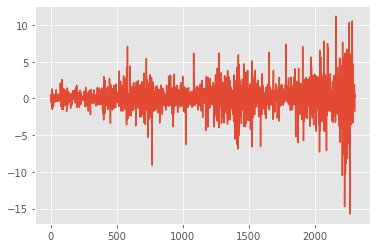

In [52]:
plt.plot(diff)

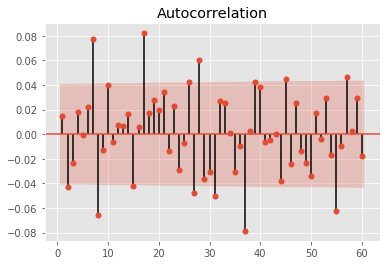

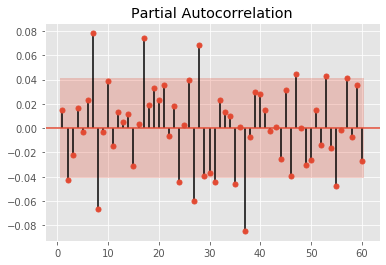

In [53]:
plot_acf(diff, lags=60, zero=False);
plot_pacf(diff, lags=60, zero=False);

### ARIMA with Python
The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

*  Define the model by calling ARIMA() and passing in the p, d, and q parameters.
* The model is prepared on the training data by calling the fit() function.
* Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire close price.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 18 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

ARIMA is a simple yet powerful model. It assumes that the historic values dictate behaviour of present. It also assumes that the data does not contain anomalies, is stationary and model parameters along with error term is constant.

ARIMA(…) creates ARIMA model. Fits() fits ARIMA(p,d,q) model by exact maximum likelihood via Kalman filter and Forecast() returns an estimated value based on the fitted ARIMA model.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
	model = ARIMA(Actual, order=(P, D, Q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction

#new arrays to store actual and predictions
Actual = train.Close.values.tolist()
Predictions = list()


#in a for loop, predict values using ARIMA model
for timepoint in range(len(train)):
	ActualValue =  train.Close.values[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	#add it in the list
	Predictions.append(Prediction[0])
	Actual.append(ActualValue)

In [ ]:
ar_train = train[['Close']]
ar_train.columns = ['Real']
ar_train['Pred'] = Predictions

# Checking the auto regressive model error
error_train['Auto Regr.'] = check_error(ar_train['Real'], ar_train['Pred'])
error_train

In [56]:
!pip install qgrid
!pip install pandas_profiling

  Created wheel for qgrid: filename=qgrid-1.2.0-py2.py3-none-any.whl size=1563825 sha256=a8b170beb495e9eb9cedd83457373d5a7b46d1e17adf352ee35fa8ef8e0695fa
  Stored in directory: C:\Users\Sid\AppData\Local\pip\Cache\wheels\fb\81\85\02067fe38c88f2b9327f6a6e7a067304bc62b5e39e2791e484
Successfully built qgrid
  Created wheel for pandas-profiling: filename=pandas_profiling-2.4.0-py2.py3-none-any.whl size=195596 sha256=7bda8ac72fd645ae1f0cf4ce81089f2b43529875dab9890f87e64dc2a0fbf9f2
  Stored in directory: C:\Users\Sid\AppData\Local\pip\Cache\wheels\b2\4b\40\ff4633a59f4e7fbdfec19b8e10e353b54b5eef125c31afe51a
  Created wheel for confuse: filename=confuse-1.0.0-cp37-none-any.whl size=17494 sha256=3d1269176d659c6caaf28f7f0e345a782517271c6148a7d49e06605c9434a4e8
  Stored in directory: C:\Users\Sid\AppData\Local\pip\Cache\wheels\b0\b2\96\2074eee7dbf7b7df69d004c9b6ac4e32dad04fb7666cf943bd
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27090 sha256=9eace6785ec3d58dd1f1983

In [57]:
import qgrid
import pandas_profiling

In [58]:
qgrid.show_grid(aapl, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [59]:
pandas_profiling.ProfileReport(aapl)

## [Indepth Explanation of Arime with Python Codes](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

## [Statistical forecasting:notes on regression and time series analysis](http://people.duke.edu/~rnau/411home.htm)